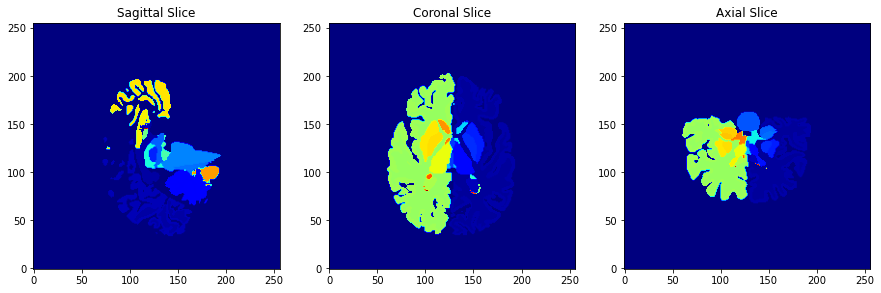

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# Load the NIfTI file
# file_path = r'D:\Juntao\Data\Accelerated_Sagittal\Segemented\116_S_4855.nii'  # Please replace with your file path
file_path = r'D:\Work\Medical image\2023\auto_noCCseg\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()

# Obtain the indices of the middle slice
slice_x = image_data.shape[0] // 2
slice_y = image_data.shape[1] // 2
slice_z = image_data.shape[2] // 2

# Extract the slices
slice_0 = image_data[slice_x, :, :]
slice_1 = image_data[:, slice_y, :]
slice_2 = image_data[:, :, slice_z]

# Plot the slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(slice_0.T, cmap='jet', origin="lower")
axes[0].set_title('Sagittal Slice')

axes[1].imshow(slice_1.T, cmap='jet', origin="lower")
axes[1].set_title('Coronal Slice')

axes[2].imshow(slice_2.T, cmap='jet', origin="lower")
axes[2].set_title('Axial Slice')

# Display the images
plt.show()


In [2]:
image_data.shape

(256, 256, 256)

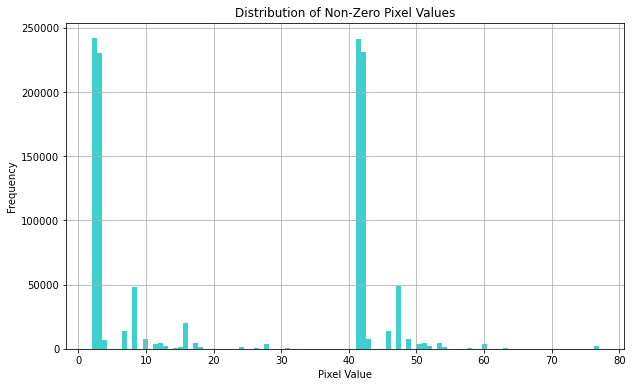

In [3]:
# Retrieve non-zero pixel values
non_zero_values = image_data[image_data > 0]

# Plot the distribution of non-zero pixel values
plt.figure(figsize=(10, 6))
plt.hist(non_zero_values.ravel(), bins=100, color='c', alpha=0.75)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Distribution of Non-Zero Pixel Values')
plt.grid(True)
plt.show()


In [4]:
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18

class SEBlock(nn.Module):
    def __init__(self, input_dim, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, input_dim // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim // reduction, input_dim, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        self.saved_attention = y
        return x * y.expand_as(x)

class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.se_block = SEBlock(planes * self.expansion)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Apply SE block
        out = self.se_block(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    def get_attention_weight(self):
        return self.se_block.saved_attention

# Load the pre-built 3D ResNet model
model = r3d_18(pretrained=True, progress=True)

# Replace the first convolution layer for single-channel input
model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

# Replace existing blocks with SEBasicBlock
def make_layer(block, inplanes, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            nn.Conv3d(inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm3d(planes * block.expansion),
        )

    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes * block.expansion
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))

    return nn.Sequential(*layers)

# if you want 18 layers, use the following
# model.layer1 = make_layer(SEBasicBlock, 64, 64, 2)
# model.layer2 = make_layer(SEBasicBlock, 64, 128, 2, stride=2)
# model.layer3 = make_layer(SEBasicBlock, 128, 256, 2, stride=2)
# model.layer4 = make_layer(SEBasicBlock, 256, 512, 2, stride=2)

# if you want 9 layers, use the following
model.layer1 = make_layer(SEBasicBlock, 64, 64, 1) 
model.layer2 = make_layer(SEBasicBlock, 64, 128, 1, stride=2)  
model.layer3 = make_layer(SEBasicBlock, 128, 256, 1, stride=2) 
model.layer4 = make_layer(SEBasicBlock, 256, 512, 1, stride=2)  

# Replace the fully connected layer for specific output size
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=3)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Using device:", device)


Using device: cuda


In [5]:
import os
import numpy as np
import nibabel as nib
import pandas as pd

# Directory paths
nii_folder_path = r'D:\Work\Medical image\2023\auto_noCCseg'
csv_file_path = r'D:\Work\Medical image\2023\11_18_2023_11_26_2023.csv'

# Label targets
label_target = ['AD', 'CN']

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Filter the dataframe based on label targets
filtered_df = df[df['Group'].isin(label_target)]

# Read .nii files and stack them into a list
data_list = []
for file_name in os.listdir(nii_folder_path):
    if file_name.endswith('.nii'):
        # Remove the file extension to get the subject ID
        subject_id = file_name.split('.')[0]

        # Check if the subject ID is in the filtered dataframe
        if subject_id in filtered_df['Subject'].values:
            file_path = os.path.join(nii_folder_path, file_name)
            image = nib.load(file_path)
            image_data = image.get_fdata()
            # Ensure the image is three-dimensional and add a new axis to represent a single channel
            if image_data.ndim == 3:
                image_data = image_data[np.newaxis, ...]  # Add single-channel dimension
            data_list.append(image_data)

# Stack the data in the list into a large NumPy array
# Assuming the size of each image is the same
data = np.vstack(data_list)
data = data[:, np.newaxis, ...]
print(f'data shape: {data.shape}')
data_list=None


data shape: (123, 1, 256, 256, 256)


In [6]:
import os
import pandas as pd
import seaborn as sns

label_dict = pd.Series(filtered_df.Group.values, index=filtered_df.Subject).to_dict()

# Read .nii files and generate labels for each file
labels = []
for file_name in os.listdir(nii_folder_path):
    if file_name.endswith('.nii'):
        # Assuming the file name contains the Subject number, and it is at the start of the file name
        subject_number = file_name[:-4]  # Removing the .nii extension
        # Get the corresponding Group as a label, if it's in the filtered list
        label = label_dict.get(subject_number)
        if label:
            labels.append(label)
        else:
            pass
            # print(f'Skipped file: {file_name}')

# Convert labels to a NumPy array (if needed)
labels_array = np.array(labels)
print(f'Labels array shape: {labels_array.shape}')
print(f'First 10 Labels: {labels_array[:10]}')

Labels array shape: (123,)
First 10 Labels: ['CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN' 'CN']


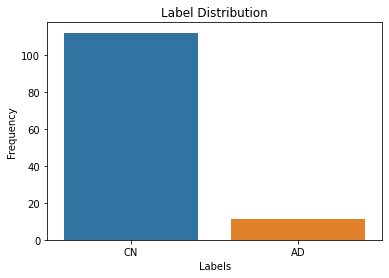

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=labels_array)

plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')

plt.show()


In [9]:
# Create an empty list to store the new integer labels
int_labels = []

# Define the mapping rule
label_mapping = {'CN': 0, 'AD': 2, 'MCI': 1, 'EMCI': 1}

# Iterate through labels_array and apply the mapping rule
for label in labels_array:
    int_label = label_mapping.get(label, -1)  # Use -1 as the default value when no match is found
    int_labels.append(int_label)

# Convert the list of integer labels to a NumPy array
int_labels_array = np.array(int_labels)

print(f'Integer Labels Array: {int_labels_array[:10]}')

Integer Labels Array: [0 0 0 0 0 0 0 0 0 0]


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming 'data' and 'labels' are numpy arrays
# Convert data and labels to PyTorch tensors and move them to the GPU if available
data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
labels_tensor = torch.tensor(int_labels_array, dtype=torch.long).to(device)

# Create a dataset from tensors
dataset = TensorDataset(data_tensor, labels_tensor)

# Split the dataset into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Model, loss function, and optimizer initialization remains the same
model = model.to(device)  # Ensure model is on the same device
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class problems
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training loop
records = pd.DataFrame(columns=['Epoch', 'Loss', 'Accuracy', 'Val_Loss', 'Val_Accuracy'])
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print loss for each epoch
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')
    print(f'Training Accuracy: {100 * correct / total}%')
    training_accuracy = 100 * correct / total if total > 0 else 0

    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print results on validation set
    print(f'Validation Loss: {val_loss / len(val_loader)}')
    print(f'Validation Accuracy: {100 * correct / total}%')
    validation_accuracy = 100 * correct / total if total > 0 else 0

    epoch_record = pd.DataFrame([{
        'Epoch': epoch + 1,
        'Loss': running_loss / len(train_loader),
        'Accuracy': training_accuracy,
        'Val_Loss': val_loss / len(val_loader),
        'Val_Accuracy': validation_accuracy
    }])
    records = pd.concat([records, epoch_record], ignore_index=True)
    if (epoch + 1) % 3 == 0:
        torch.save(model.state_dict(), f'model_weights_epoch_{epoch+1}.pth')
        records.to_csv(f'training_records_epoch_{epoch+1}.csv', index=False)


records.to_csv('final_training_records.csv', index=False)


RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 10.00 GiB total capacity; 22.87 GiB already allocated; 0 bytes free; 22.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
total_params = sum(p.numel() for p in model.parameters())

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 33236035
Trainable parameters: 33236035


In [16]:
model.eval

<bound method Module.eval of VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): SEBasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se_block): SEBlock(
        (avg_pool): AdaptiveAvgPool3d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_feat

RuntimeError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 10.00 GiB total capacity; 23.06 GiB already allocated; 0 bytes free; 23.08 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
torch.save(model.state_dict(), f'model_weights_epoch_{epoch+1}.pth')

In [10]:
records.to_csv(f'training_records_epoch_{epoch+1}.csv', index=False)

In [ ]:
import os
import pandas as pd

# Path to the CSV file
csv_file_path = r'D:\Juntao\Data\ANDI3-T1\11_18_2023_11_19_2023.csv'
# # Path to the directory
# folder_path = r'D:\Juntao\Data\Accelerated_Sagittal\Segemented'

# Read the CSV file
labels_df = pd.read_csv(csv_file_path)

# Create a dictionary mapping Subject to Group
label_dict = pd.Series(labels_df.Group.values, index=labels_df.Subject).to_dict()

# Read .nii files and generate labels for each file
labels = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.nii'):
        # Assuming the file name contains the Subject number, and it is at the start of the file name
        subject_number = file_name[:-4]
        # Get the corresponding Group as a label
        label = label_dict.get(subject_number)
        if label is not None:
            labels.append(label)
        else:
            print(file_name)

# Convert labels to a NumPy array (if needed)
labels_array = np.array(labels)
print(labels_array.shape)
print(f'Labels: {labels_array[:10]}')


In [12]:
epoch_record = pd.DataFrame([{
        'Epoch': epoch + 1,
        'Loss': running_loss / len(train_loader),
        'Accuracy': training_accuracy,
        'Val_Loss': val_loss / len(val_loader),
        'Val_Accuracy': validation_accuracy
    }])
records = pd.concat([records, epoch_record], ignore_index=True)
if (epoch + 1) % 10 == 0:
    torch.save(model.state_dict(), f'model_weights_epoch_{epoch+1}.pth')
    records.to_csv(f'training_records_epoch_{epoch+1}.csv', index=False)

C:\Users\duson\AppData\Local\Temp\ipykernel_1488\16814281.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  records = pd.concat([records, epoch_record], ignore_index=True)


In [13]:
records

,Epoch,Loss,Accuracy,Val_Loss,Val_Accuracy
0,1,0.912853,63.285024,1.036249,59.615385


In [8]:
weights_path = r'D:\Juntao\Code\model_weights.pth'
model.load_state_dict(torch.load(weights_path))
model.eval()

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): SEBasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se_block): SEBlock(
        (avg_pool): AdaptiveAvgPool3d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
        

In [9]:
class ModifiedR3D18(nn.Module):
    def __init__(self, original_model):
        super(ModifiedR3D18, self).__init__()
        # 将原始模型的所有层复制过来
        self.stem = original_model.stem
        self.layer1 = original_model.layer1
        self.layer2 = original_model.layer2
        self.layer3 = original_model.layer3
        self.layer4 = original_model.layer4
        self.avgpool = original_model.avgpool
        self.fc = original_model.fc

        # 初始化一个字典来保存特征图
        self.feature_maps = {}
        self.attention_weights = {}
        
    def forward(self, x):
        # 逐层前向传播，同时保存特征图
        x = self.stem(x)
        self.feature_maps['stem'] = x

        x = self.layer1(x)
        self.feature_maps['layer1'] = x

        x = self.layer2(x)
        self.feature_maps['layer2'] = x

        x = self.layer3(x)
        self.feature_maps['layer3'] = x

        x = self.layer4(x)
        self.feature_maps['layer4'] = x

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        for name, module in self.named_modules():
            if isinstance(module, SEBasicBlock):
                self.attention_weights[name] = module.get_attention_weight()

        return x


In [11]:
modified_model = ModifiedR3D18(model).to(device)
output = modified_model(torch.tensor(image_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device))


feature_maps = modified_model.feature_maps['layer1']  # 特征图
attention_weights = modified_model.attention_weights['layer1.0']  # 以此类推


In [12]:
attention_weights.shape

torch.Size([1, 64, 1, 1, 1])

In [13]:
feature_maps.shape

torch.Size([1, 64, 256, 128, 128])

In [28]:
import torch.nn.functional as F

# 假设
# attention_weights.shape = [1, 64, 1, 1, 1]
# feature_maps.shape = [1, 64, 256, 128, 128]

# 扩展注意力权重以匹配特征图的空间维度
expanded_attention_weights = attention_weights.expand_as(feature_maps)

# 将注意力权重应用到特征图上
weighted_feature_maps = feature_maps * expanded_attention_weights

# 上采样加权特征图以匹配原始图像尺寸
# 假设原始图像尺寸为 [256, 256, 256]
upsampled_feature_maps = F.interpolate(
    weighted_feature_maps,
    size=(256, 256, 256),
    mode='trilinear',
    align_corners=True
)

# 合并所有通道以生成热力图
# 使用平均或求和根据需求选择
heatmap = torch.mean(upsampled_feature_maps, dim=1).squeeze()

# heatmap 现在是一个 [256, 256, 256] 尺寸的热力图


In [29]:
heatmap.shape

torch.Size([256, 256, 256])

In [30]:
heatmap = heatmap.cpu().detach().numpy()

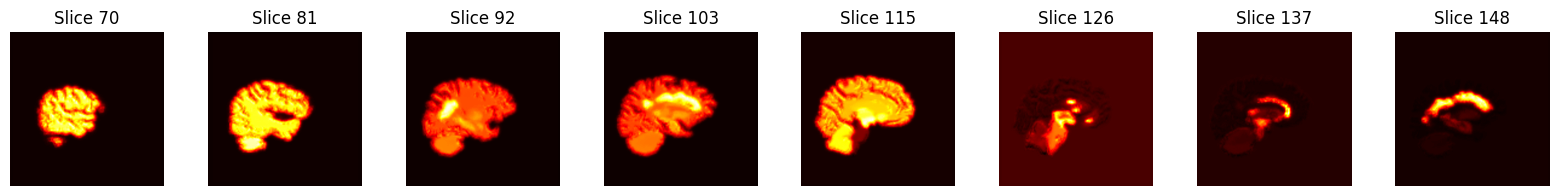

In [31]:
import matplotlib.pyplot as plt
import numpy as np

start_slice = 70
end_slice = 160
num_slices = 8

slices_indices = np.linspace(start_slice, end_slice, num_slices, endpoint=False, dtype=int)

fig, axes = plt.subplots(1, num_slices, figsize=(20, 2))

for i, idx in enumerate(slices_indices):
    axes[i].imshow(heatmap[idx, :, :], cmap='hot')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')

plt.show()


In [33]:
def save_features(module, input, output):
    module.saved_features = output
def save_gradients(module, input, output):
    module.saved_gradients = input[0]
# 假设 target_layer 是您选择进行可视化的层
target_layer = model.layer4[0]  # 例如，选择 model.layer4 的第一个子模块

# 注册钩子
target_layer.register_forward_hook(save_features)
target_layer.register_backward_hook(save_gradients)


In [48]:
# 前向传播
input_tensor = torch.tensor(image_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device) # 您的输入张量，形状为 [1, C, D, H, W]
input_tensor.requires_grad_(True)

# 如果模型在评估模式下，切换到训练模式
model.eval()

# 执行前向传播
output = model(input_tensor)

# 获取目标类别的输出
target_class = 0 # 目标类别的索引
target = output[0, target_class]

# 反向传播以获取目标类别相对于目标层输出的梯度
model.zero_grad()
target.backward()

In [49]:
features = target_layer.saved_features
gradients = target_layer.saved_gradients
print(features.shape)
print(gradients.shape)

torch.Size([1, 512, 32, 16, 16])
torch.Size([1, 512, 32, 16, 16])


In [50]:
# 获取特征图和梯度
features = features[0]  # 从 [1, 512, 32, 16, 16] 到 [512, 32, 16, 16]
gradients = gradients[0]  # 从 [1, 512, 32, 16, 16] 到 [512, 32, 16, 16]

# 计算每个通道的权重（全局平均池化）
weights = torch.mean(gradients, dim=[1, 2, 3])  # 在空间维度上计算平均值

# 生成热力图
gcam = torch.zeros_like(features[0]).to(device)  # 初始化热力图
for i, w in enumerate(weights):
    gcam += w * features[i]

# ReLU on top of the heatmap
gcam = F.relu(gcam)

# 热力图归一化处理
gcam -= gcam.min()
gcam /= gcam.max()

# 上采样到原始图像的大小
# 假设原始图像的大小是 [D, H, W]，您需要将这个尺寸提供给代码
original_size = (256, 256, 256)  # 替换为您的原始尺寸
gcam = F.interpolate(gcam.unsqueeze(0).unsqueeze(0), size=original_size, mode='trilinear', align_corners=False).squeeze()

# 现在 gcam 是一个 [D, H, W] 形状的3D热力图


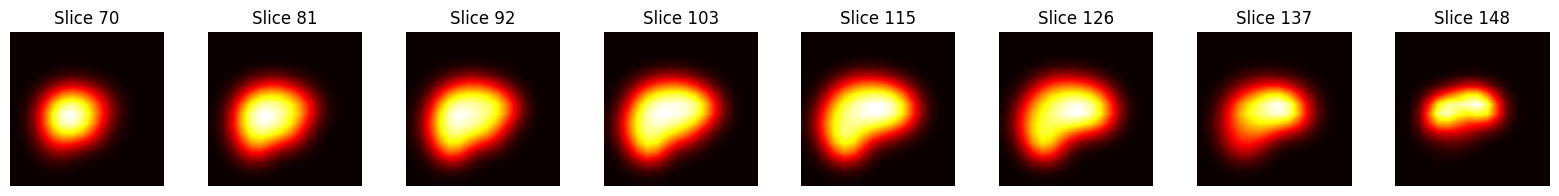

In [51]:
import matplotlib.pyplot as plt
import numpy as np

start_slice = 70
end_slice = 160
num_slices = 8
gcam_np=gcam.cpu().detach().numpy()
slices_indices = np.linspace(start_slice, end_slice, num_slices, endpoint=False, dtype=int)

fig, axes = plt.subplots(1, num_slices, figsize=(20, 2))

for i, idx in enumerate(slices_indices):
    axes[i].imshow(gcam_np[idx, :, :], cmap='hot')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')

plt.show()


## 3D Lime

### Define pertubation mathod

In [61]:
import numpy as np
import random

def apply_3d_mask(input_data, mask_size, n_masks):
    # input_data: 3D numpy array
    # mask_size: size of the cube used to mask the data
    # n_masks: number of masks to apply
    perturbed_data = np.copy(input_data)
    masks = []

    for _ in range(n_masks):
        # Randomly choose the corner of the mask
        corner = [random.randint(0, dim - mask_size) for dim in input_data.shape]
        mask = np.zeros_like(input_data)
        
        # Apply the mask
        mask[corner[0]:corner[0]+mask_size, 
             corner[1]:corner[1]+mask_size, 
             corner[2]:corner[2]+mask_size] = 1
        perturbed_data *= (1 - mask)
        masks.append(mask.flatten())

    return perturbed_data, np.array(masks)


### generate pertubated samples

In [62]:
def generate_perturbations(input_data, mask_size, n_samples, n_masks_per_sample):
    perturbed_samples = []
    masks = []
    
    for _ in range(n_samples):
        perturbed, mask = apply_3d_mask(input_data, mask_size, n_masks_per_sample)
        perturbed_samples.append(perturbed)
        masks.append(mask)
    
    return np.array(perturbed_samples), np.array(masks)

### make predictions

In [63]:
def predict_with_model(model, perturbed_samples):
    predictions = []
    for sample in perturbed_samples:
        sample_tensor = torch.tensor(sample[np.newaxis, np.newaxis, ...]).to(device)
        with torch.no_grad():
            prediction = model(sample_tensor)
            predictions.append(prediction.cpu().numpy())
    return np.array(predictions)

### train a linear regression

In [64]:
from sklearn.linear_model import LinearRegression

def train_explainer(original_prediction, perturbed_predictions, masks, target_class):
    # Linear model to learn the relationship between mask presence and model output
    linear_model = LinearRegression()
    labels = perturbed_predictions[:, target_class] - original_prediction[target_class]
    linear_model.fit(masks, labels)
    return linear_model.coef_

### generate heatmap

In [65]:
import matplotlib.pyplot as plt

def display_heatmap(coefficients, shape):
    heatmap = coefficients.reshape(shape)
    start_slice = 70
    end_slice = 160
    num_slices = 8
    slices_indices = np.linspace(start_slice, end_slice, num_slices, endpoint=False, dtype=int)
    
    fig, axes = plt.subplots(1, num_slices, figsize=(20, 2))
    
    for i, idx in enumerate(slices_indices):
        axes[i].imshow(heatmap[idx, :, :], cmap='hot')
        axes[i].set_title(f'Slice {idx}')
        axes[i].axis('off')
    
    plt.show()

# Example Usage
mask_size = 10  # Size of the masking cube
n_samples = 100  # Number of perturbed samples to generate
n_masks_per_sample = 5  # Number of masks to apply per sample
target_class = 0  # Target class for explanation

# Generate perturbed samples
perturbed_samples, masks = generate_perturbations(image_data, mask_size, n_samples, n_masks_per_sample)

# Predict with model
perturbed_predictions = predict_with_model(model, perturbed_samples)

# Original prediction
original_prediction = model(torch.tensor(input_data[np.newaxis, np.newaxis, ...]).to(device))

# Train explainer
coefficients = train_explainer(original_prediction, perturbed_predictions, masks, target_class)

# Display heatmap
display_heatmap(coefficients, input_data.shape)


MemoryError: Unable to allocate 640. MiB for an array with shape (5, 16777216) and data type float64

In [60]:
import numpy as np
import random
import torch
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 扰动函数
def perturb_superpixels(input_data, mask, n_perturbations):
    superpixels = np.unique(mask)
    perturbed_data = np.copy(input_data)
    selected_superpixels = random.sample(list(superpixels), n_perturbations)
    
    for sp in selected_superpixels:
        perturbed_data[mask == sp] = 0  # 假设将选中的超像素区域置零

    return perturbed_data

# 预测函数
def predict_with_model(model, samples):
    predictions = []
    for sample in samples:
        sample_tensor = torch.tensor(sample[np.newaxis, np.newaxis, ...], dtype=torch.float32).to(device)
        with torch.no_grad():
            prediction = model(sample_tensor)
            predictions.append(prediction.cpu().numpy())
    return np.array(predictions)

# 解释器训练函数
def train_explainer(original_prediction, perturbed_predictions, features, target_class):
    linear_model = LinearRegression()
    original_pred = original_prediction.squeeze()  # 将形状从 (1, 3) 变为 (3,)
    perturbed_preds = perturbed_predictions.squeeze(axis=1)  # 将形状从 (N, 1, 3) 变为 (N, 3)
    labels = perturbed_preds[:, target_class] - original_pred[target_class]
    linear_model.fit(features, labels)
    return linear_model.coef_

# 热力图显示函数
def display_heatmap(coefficients, shape):
    heatmap = coefficients.reshape(shape)
    # 显示逻辑（可能是多个2D切片或3D渲染）
    # ...

# 执行LIME分析
n_samples = 10  # 扰动样本的数量
n_perturbations = 5  # 每个样本扰动的超像素数量
target_class = 1  # 目标类别

# 原始数据和mask
input_data = np.copy(image_data)  # 假设 image_data 是原始的3D数据
mask = np.copy(image_data)   # 假设 superpixel_mask 是超像素mask

# 生成扰动样本
perturbed_samples = []
features = []
for _ in range(n_samples):
    perturbed = perturb_superpixels(input_data, mask, n_perturbations)
    perturbed_samples.append(perturbed)

# 预测
original_prediction = predict_with_model(model, [input_data])[0]
perturbed_predictions = predict_with_model(model, perturbed_samples)

# 生成特征矩阵
unique_superpixels = np.unique(mask)
features = np.array([mask == sp for sp in unique_superpixels]).astype(float).T.reshape(len(unique_superpixels), -1)

# 训练解释器
coefficients = train_explainer(original_prediction, perturbed_predictions, features, target_class)

# 显示热力图
display_heatmap(coefficients, input_data.shape)


ValueError: Found input variables with inconsistent numbers of samples: [36, 10]

In [61]:
features = np.zeros((n_samples, len(unique_superpixels)))

for i, perturbed in enumerate(perturbed_samples):
    # 对于每个扰动样本，确定哪些超像素被激活
    for j, sp in enumerate(unique_superpixels):
        # 如果超像素在该扰动样本中被激活，则设置相应的特征为1
        features[i, j] = 1 if np.any(perturbed[mask == sp] != input_data[mask == sp]) else 0

# 现在features的形状应该是 (n_samples, len(unique_superpixels))
# 生成labels
labels = perturbed_predictions.squeeze(axis=1)[:, target_class] - original_prediction[0, target_class]

# 训练线性回归模型
linear_model = LinearRegression()
linear_model.fit(features, labels)
coefficients = linear_model.coef_

# 展示热力图
display_heatmap(coefficients, input_data.shape)

ValueError: cannot reshape array of size 36 into shape (256,256,256)

In [2]:
import os
import csv
import nibabel as nib

def convert_mgz_to_nii(mgz_file, nii_file):
    try:
        # Load the MGZ file
        mgz_image = nib.load(mgz_file)
        # Save it as a NII file
        nib.save(mgz_image, nii_file)
    except Exception as e:
        raise Exception(f"Error converting {mgz_file}: {e}")

def copy_and_rename_files(source_dir, dest_dir, error_report_file):
    errors = []

    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file == 'aseg.auto_noCCseg.mgz':
                try:
                    source_file = os.path.join(root, file)
                    subdir_name = os.path.basename(os.path.dirname(root))
                    dest_file = os.path.join(dest_dir, subdir_name + '.nii')

                    convert_mgz_to_nii(source_file, dest_file)
                except Exception as e:
                    print(f"Error processing {source_file}: {e}")
                    errors.append(subdir_name)

    with open(error_report_file, 'w', newline='') as file:
        writer = csv.writer(file)
        for error in errors:
            writer.writerow([error])

# Change these paths to match your directories
source_directory = 'E:\\2023\\segemented_raw'
destination_directory = 'D:\\Work\\Medical image\\2023\\segemented_raw'
error_report_path = 'D:\\Work\\Medical image\\2023\\error_report.csv'

# Uncomment this line to run the script in your environment
copy_and_rename_files(source_directory, destination_directory, error_report_path)
